# MATH 4340 / COSC 4340: Numerical Methods for Differential Equations
# Notebook 9: Collocation and Finite Element Methods

### Professor: Dane Taylor
### Date: Spring 2024


In [2]:
%pylab inline
from scipy.optimize import fixed_point as fp
from scipy import optimize

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 1. Collocation Example


In [3]:
# c2 = 1-c1
# c1   = ( 3 - e^(-2t) ) /  ( e^(2t) - e^(-2t) ) 

c1 = ( 3 - exp(-2) ) /  ( exp(2) - exp(-2) ) 
c2 = 1-c1

true_soln = lambda t: c1*exp(2*t) + c2*exp(-2*t)

t0,T,N = 0,1,2

yi =zeros(N+1)
yi[0] = 1
yi[-1] = 3

ti = linspace(t0,T,N+1)
h = ti[1]-ti[0]
ti

array([0. , 0.5, 1. ])

In [4]:
c = -2-4*h**2
M = array([[1,0,0],[-4,-2,1],[1,1,1]])
print(M)

b = array([1,0,3])
print(b)

[[ 1  0  0]
 [-4 -2  1]
 [ 1  1  1]]
[1 0 3]


In [5]:
cj = linalg.solve(M,b)
cj

array([ 1.        , -0.66666667,  2.66666667])

In [6]:
def yy(cj,t):
    yi = zeros(len(t))
    for j,c in enumerate(cj):
        yi = yi + c*t**j
    
    return yi

yy(cj,ti)

array([1.        , 1.33333333, 3.        ])

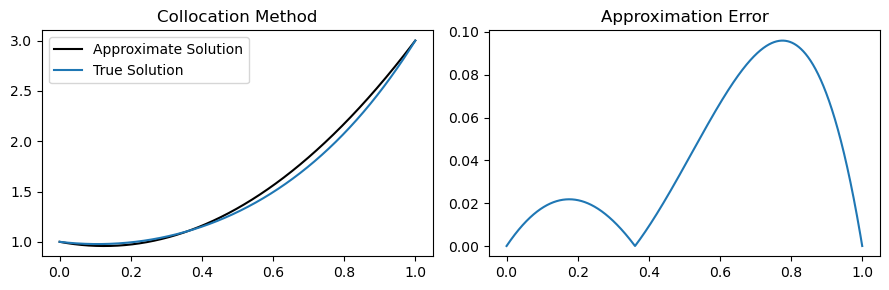

In [7]:
def collocation_fig(ti,yi,cj):

    fig1, ax = subplots(1,2, figsize=(9,3))

    tt = linspace(t0,T,10000)

    ax[0].plot(tt,yy(cj,tt),c='k')
    ax[0].plot(tt,true_soln(tt))
    ax[0].legend(['Approximate Solution','True Solution'])
    ax[0].set_title('Collocation Method')

    ax[1].plot(tt,abs(true_soln(tt) - yy(cj,tt)) )
    ax[1].set_title('Approximation Error')
    plt.tight_layout()
    
    return fig1,ax

fig1,ax = collocation_fig(ti,yi,cj)

In [8]:
[j for j in range(1,N)] 

[1]

### Now lets consider general N

In [9]:
N=2
ti = linspace(0,1,N+1)
h = 1/N
M = zeros((N+1,N+1))
M[0,0] = 1
M[-1,:] = ones(N+1)

for i in range(1,N):
    row = array( [j*(j-1)*ti[i]**(j-2) - 4*ti[i]**j for j in range(N+1)] )
    M[i] = row

print(M)

[[ 1.  0.  0.]
 [-4. -2.  1.]
 [ 1.  1.  1.]]


In [10]:
b = zeros(N+1)
b[0] = 1 
b[-1] = 3
print(b)

[1. 0. 3.]


In [11]:
cj = linalg.solve(M,b)
cj

array([ 1.        , -0.66666667,  2.66666667])

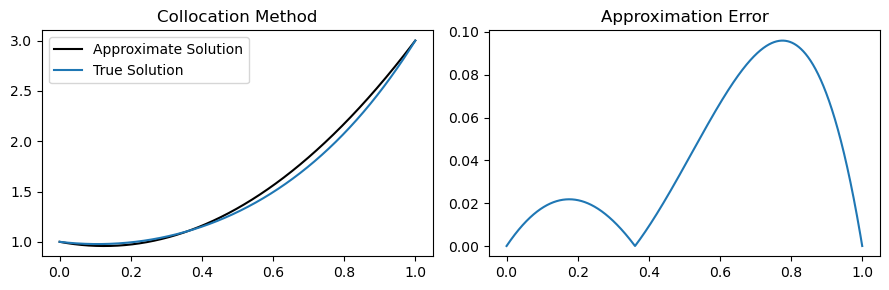

In [12]:
fig1,ax = collocation_fig(ti,yi,cj)

#### Consider larger N

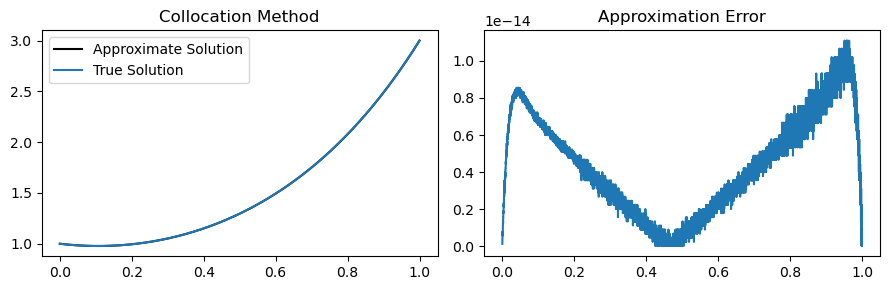

In [13]:
N=14
ti = linspace(0,1,N+1)
h = 1/N
M = zeros((N+1,N+1))
M[0,0] = 1
M[-1,:] = ones(N+1)

for i in range(1,N):
    row = array( [j*(j-1)*ti[i]**(j-2) - 4*ti[i]**j for j in range(N+1)] )
    M[i] = row

b = zeros(N+1)
b[0] = 1 
b[-1] = 3

cj = linalg.solve(M,b)

fig1,ax = collocation_fig(ti,yi,cj)

## 2. Galerkin Finite Element Method

* First let's study B-splines

In [14]:
def phi(j,t,ti):
    phi = zeros(len(t))
    
    if j==0:
        times = where(t<=ti[j+1])
        phi[times] = (ti[1]-t[times]) / ( ti[1]-ti[0] )

    elif j==(len(ti)-1):
        times = where(t>=ti[j-1])
        phi[times] = (t[times]-ti[-2]) / ( ti[-1]-ti[-2] )

    else:
        times = where( (t>ti[j-1]) * (t<=ti[j]) )
        phi[times] = (t[times]-ti[j-1]) / ( ti[j]-ti[j-1] )
        times = where( (t>ti[j]) & (t<=ti[j+1]) )
        phi[times] = (ti[j+1]-t[times]) / ( ti[j+1]-ti[j] )
    
    return phi

In [15]:
N=4
ti = linspace(0,1,N+1)
print(ti)

[0.   0.25 0.5  0.75 1.  ]


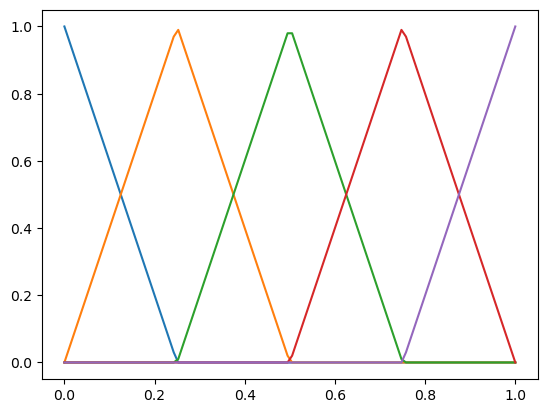

In [17]:
tt = linspace(0,1,100)

for j in range(N+1):
    plot(tt,phi(j,tt,ti))

### Now let's construct a solution

In [43]:
N=3
ti = linspace(0,1,N+1)
h = 1/N
alpha = 8/3*h+2/h
beta = 2/3*h-1/h

M = diag(alpha*ones(N-1),0) +diag(beta*ones(N-2),1) +diag(beta*ones(N-2),-1)
print(M)

[[ 6.88888889 -2.77777778]
 [-2.77777778  6.88888889]]


In [44]:
b = zeros(N-1)
b[0] = -1*beta 
b[-1] = -3*beta
print(b)

[2.77777778 8.33333333]


In [45]:
cj = zeros(N+1)
cj[0] = 1
cj[N] = 3
cj[1:N] = linalg.solve(M,b)
cj

array([1.        , 1.06399503, 1.63870767, 3.        ])

In [46]:
def y_fun(cj,t):
    yy = zeros(len(t))
    for j,c in enumerate(cj):
        yy = yy + c*phi(j,t,ti)
    return yy


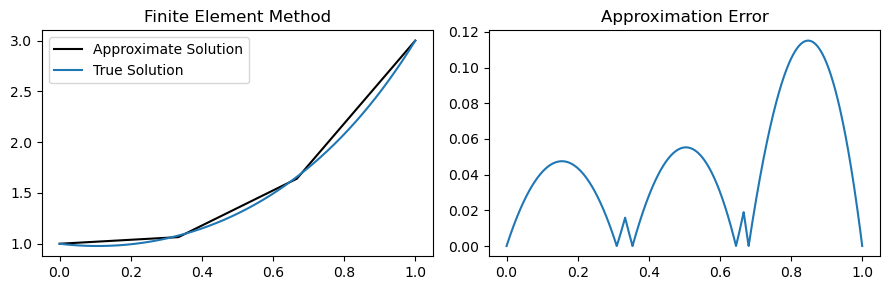

In [47]:
def finite_element_fig(ti,yi,cj):

    fig1, ax = subplots(1,2, figsize=(9,3))

    tt = linspace(t0,T,10000)

    ax[0].plot(tt,y_fun(cj,tt),c='k')
    ax[0].plot(tt,true_soln(tt))
    ax[0].legend(['Approximate Solution','True Solution'])
    ax[0].set_title('Finite Element Method')

    ax[1].plot(tt,abs(true_soln(tt) - y_fun(cj,tt) ) )
    ax[1].set_title('Approximation Error')
    plt.tight_layout()
    
    return fig1,ax

fig1,ax = finite_element_fig(ti,yi,cj)